In [13]:
import yfinance as yf
import pandas as pd
import numpy as np

# Fetch Data
ticker = "SPY"
data = yf.download(ticker, start="2000-01-01", end="2025-01-01")
df = data[['Close']].copy()
df.columns = ['Adj Close'] 
print(df.head())

/var/folders/2w/y8r5wlq93_19v2h8_4fzf4tm0000gn/T/ipykernel_7423/3857423796.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2000-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

            Adj Close
Date                 
2000-01-03  91.887787
2000-01-04  88.294395
2000-01-05  88.452370
2000-01-06  87.030754
2000-01-07  92.085159


In [14]:
# Calculate Log Returns
df['Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

# Calculate Rolling Volatility
df['Volatility'] = df['Returns'].rolling(window=21).std()

# 3. Cleaning Data
df.dropna(inplace=True)

print(df.head())

            Adj Close   Returns  Volatility
Date                                       
2000-02-02  89.123665  0.000887    0.021025
2000-02-03  90.466217  0.014952    0.019352
2000-02-04  90.091064 -0.004156    0.019386
2000-02-07  89.952881 -0.001535    0.019000
2000-02-08  91.176979  0.013516    0.014600


In [15]:
from hmmlearn.hmm import GaussianHMM

# Prepare the data for the HMM
X = df[['Returns', 'Volatility']].values

# Initialize the model
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=100, random_state=42)
print("Training HMM...")
model.fit(X)

# Predict the hidden states for each day
hidden_states = model.predict(X)

df['Regime'] = hidden_states

print("Training Complete. Last 10 days of regimes:")
print(df[['Adj Close', 'Regime']].tail(10))

Training HMM...


Model is not converging.  Current: 48804.59630754116 is not greater than 48805.066245449416. Delta is -0.46993790825945325


Training Complete. Last 10 days of regimes:
             Adj Close  Regime
Date                          
2024-12-17  597.031555       1
2024-12-18  579.237915       1
2024-12-19  579.060059       1
2024-12-20  586.015137       1
2024-12-23  589.524353       1
2024-12-24  596.076904       1
2024-12-26  596.116699       1
2024-12-27  589.841614       1
2024-12-30  583.110596       1
2024-12-31  580.989197       1


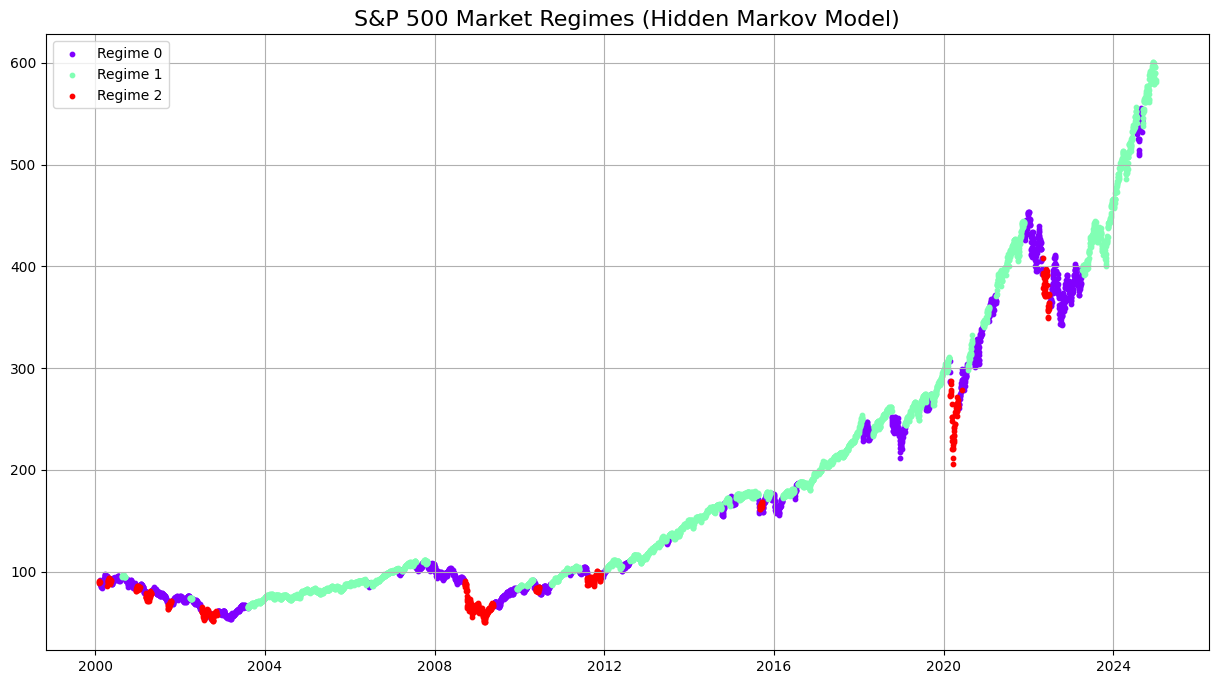

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create plot
plt.figure(figsize=(15, 8))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))
for i, color in enumerate(colors):
    mask = df['Regime'] == i
    plt.scatter(
        df.index[mask], 
        df['Adj Close'][mask], 
        c=[color],
        label=f'Regime {i}', 
        s=10
    )

plt.title('S&P 500 Market Regimes (Hidden Markov Model)', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Mapping the regimes based on visual inspection
df['Signal'] = np.where(df['Regime'] == 1, 1, 0)

# Shift the Signal
df['Signal'] = df['Signal'].shift(1)

# 3. Calculate Strategy Returns
df['Strategy_Returns'] = df['Returns'] * df['Signal']

# 4. Calculate Cumulative Returns
df['Buy_Hold_Cum'] = np.exp(df['Returns'].cumsum())
df['Strategy_Cum'] = np.exp(df['Strategy_Returns'].cumsum())

print("Backtest Complete. Calculating Performance...")

Backtest Complete. Calculating Performance...


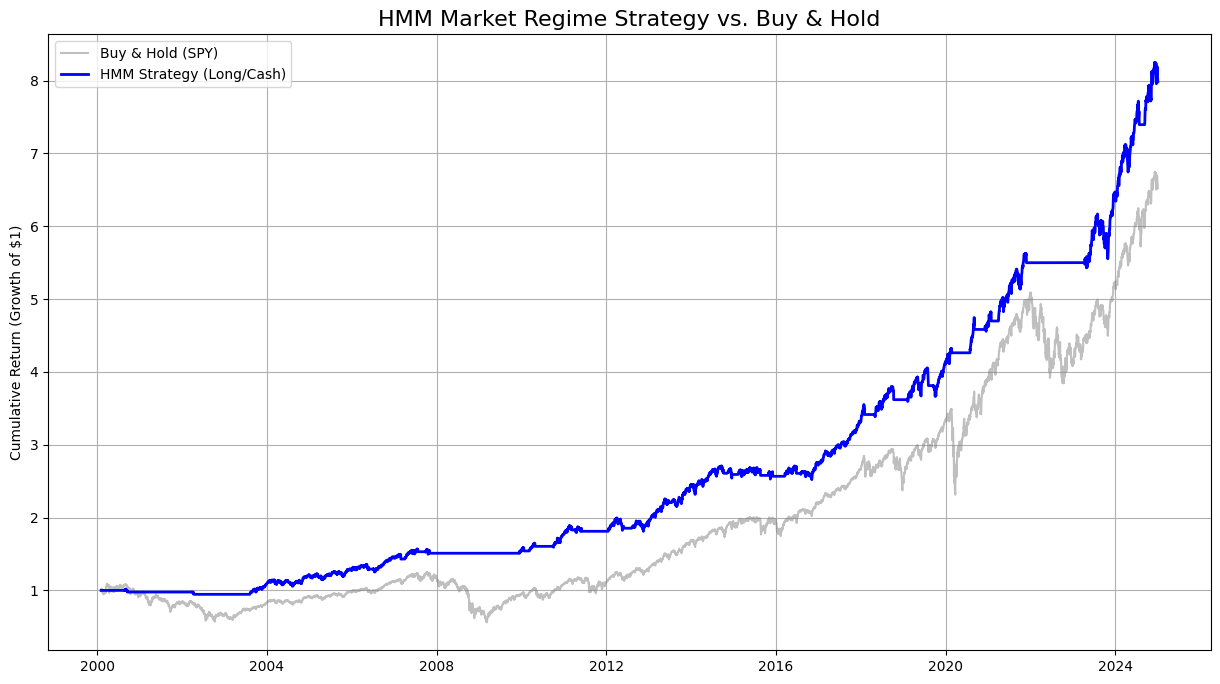

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Plot Buy & Hold
plt.plot(df.index, df['Buy_Hold_Cum'], label='Buy & Hold (SPY)', color='gray', alpha=0.5)

# Plot HMM Strategy
plt.plot(df.index, df['Strategy_Cum'], label='HMM Strategy (Long/Cash)', color='blue', linewidth=2)

plt.title('HMM Market Regime Strategy vs. Buy & Hold', fontsize=16)
plt.ylabel('Cumulative Return (Growth of $1)')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Calculate Total Return
total_return_bh = df['Buy_Hold_Cum'].iloc[-1] - 1
total_return_strat = df['Strategy_Cum'].iloc[-1] - 1

# Calculate Annualized Volatility
vol_bh = df['Returns'].std() * np.sqrt(252)
vol_strat = df['Strategy_Returns'].std() * np.sqrt(252)

# Calculate Sharpe Ratio
sharpe_bh = (df['Returns'].mean() * 252) / vol_bh
sharpe_strat = (df['Strategy_Returns'].mean() * 252) / vol_strat

print(f"--- Performance Metrics ---")
print(f"Total Return (Buy & Hold): {total_return_bh:.2%}")
print(f"Total Return (HMM Strategy): {total_return_strat:.2%}")
print(f"")
print(f"Annual Volatility (Buy & Hold): {vol_bh:.2%}")
print(f"Annual Volatility (HMM Strategy): {vol_strat:.2%}")
print(f"")
print(f"Sharpe Ratio (Buy & Hold): {sharpe_bh:.2f}")
print(f"Sharpe Ratio (HMM Strategy): {sharpe_strat:.2f}")

--- Performance Metrics ---
Total Return (Buy & Hold): 552.47%
Total Return (HMM Strategy): 698.32%

Annual Volatility (Buy & Hold): 19.34%
Annual Volatility (HMM Strategy): 8.01%

Sharpe Ratio (Buy & Hold): 0.39
Sharpe Ratio (HMM Strategy): 1.04


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.361%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2000-02-03
End date,2024-12-31
Total months,298
,Backtest
Annual return,8.361%
Cumulative returns,636.709%
Annual volatility,8.015%
Sharpe ratio,1.04
Calmar ratio,0.82
Stability,0.97
Max drawdown,-10.147%


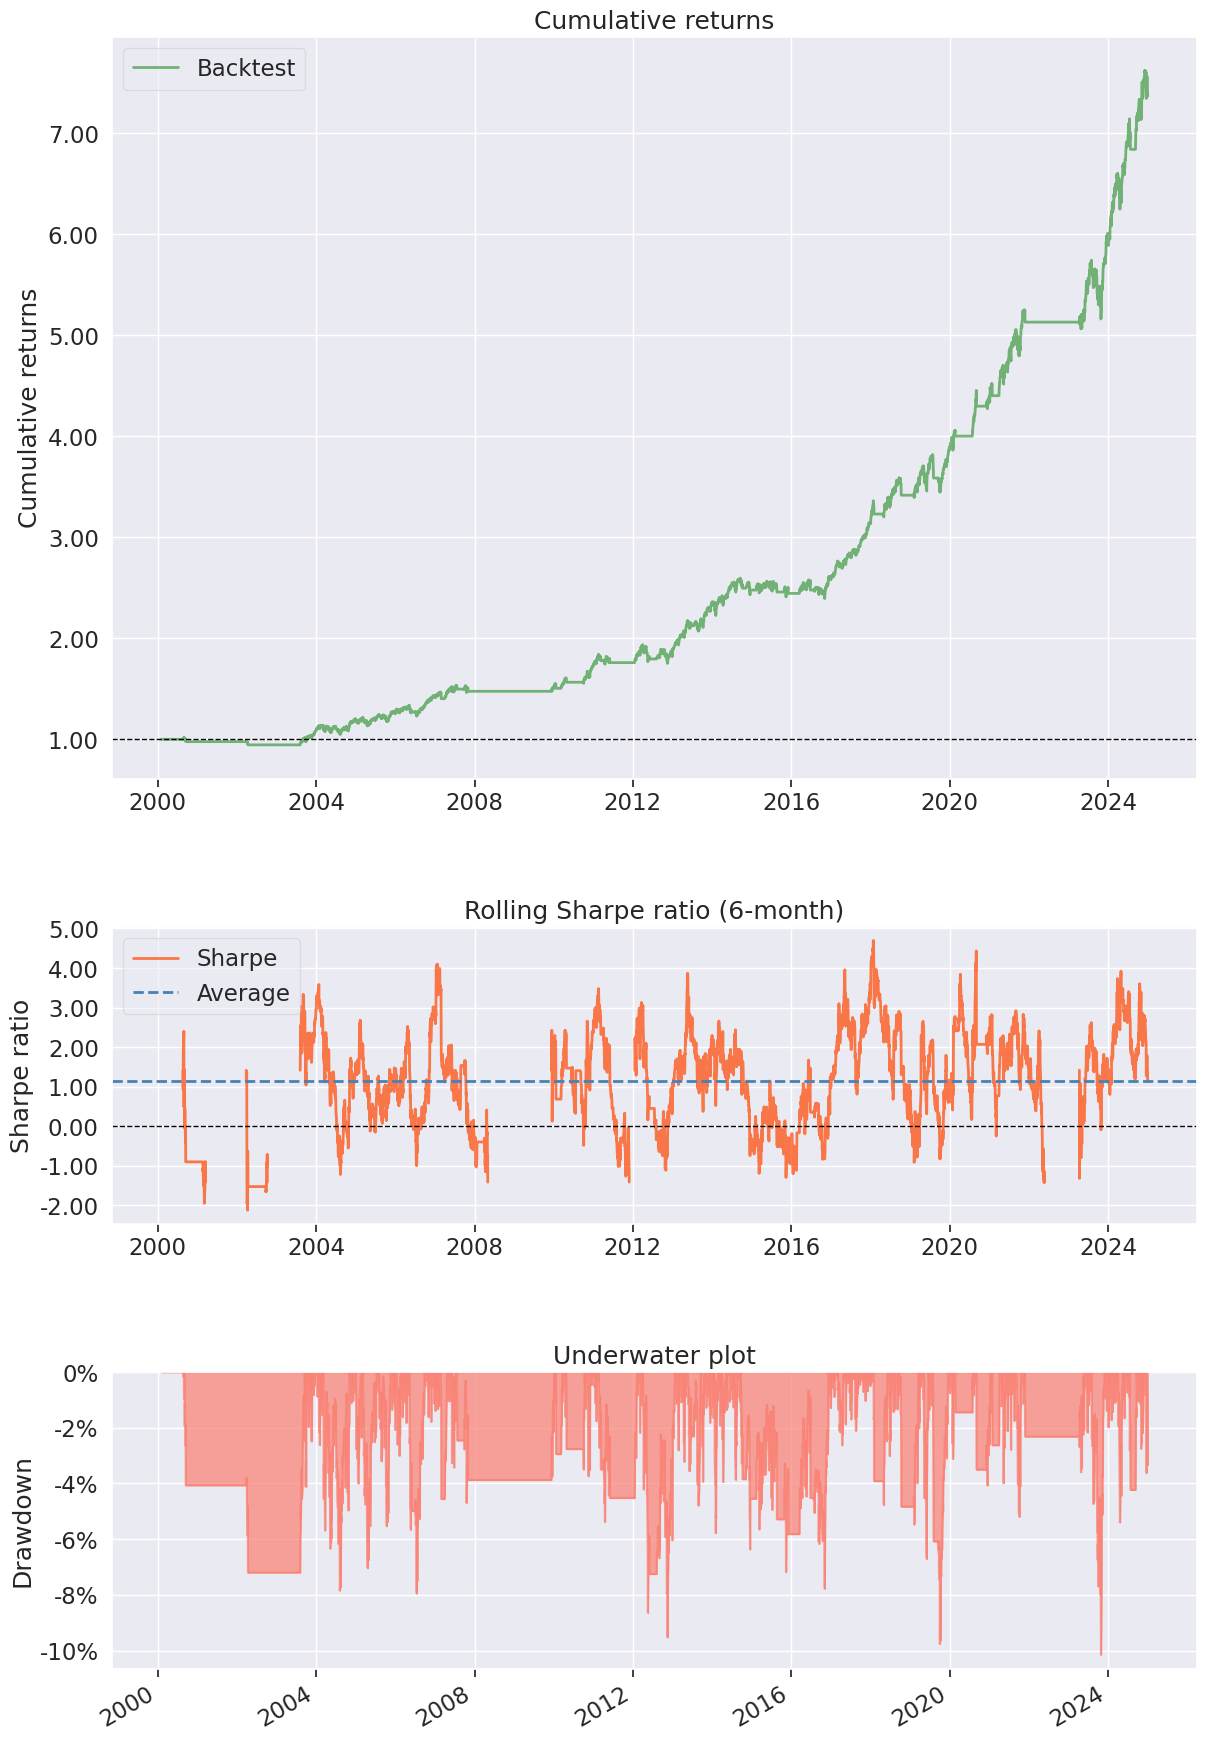

In [20]:
import pyfolio as pf
strategy_returns = df['Strategy_Returns'].dropna()

# Create the tear sheet
pf.create_simple_tear_sheet(strategy_returns)

In [21]:
import warnings
from sklearn.exceptions import ConvergenceWarning
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define Walk-Forward Parameters
start_train_size = 1250
rebalance_period = 10
total_days = len(df)

# Initialize Storage Lists
signals = []
dates = []

print(f"Setup Complete. Ready to run analysis on {total_days - start_train_size} trading days.")

Setup Complete. Ready to run analysis on 5018 trading days.


In [22]:
print("Starting Walk-Forward Loop...")

for t in range(start_train_size, total_days, rebalance_period):
    
    # Train on Past Data Only
    train_data = df.iloc[:t]
    X_train = train_data[['Returns', 'Volatility']].values
    
    # Configure Model with Stabilization Parameters
    model = GaussianHMM(n_components=3, 
                        covariance_type="full", 
                        n_iter=1000, 
                        tol=0.01, 
                        min_covar=0.001, 
                        random_state=42)
    
    # Fit the Model
    try:
        model.fit(X_train)
    except Exception as e:
        signals.extend([0] * rebalance_period)
        dates.extend(df.index[t:t+rebalance_period])
        continue
    
    # Identify the "Bull" State
    best_sharpe = -999
    bull_state_id = 0
    
    for i in range(model.n_components):
        mean_return = model.means_[i][0]
        mean_vol = model.means_[i][1]
        
        # Calculate Sharpe
        sharpe = mean_return / (mean_vol + 0.00001)
        
        if sharpe > best_sharpe:
            best_sharpe = sharpe
            bull_state_id = i
            
    # Predict for the Next Period
    if t + rebalance_period > total_days:
        end_idx = total_days
    else:
        end_idx = t + rebalance_period
        
    next_chunk = df.iloc[t:end_idx][['Returns', 'Volatility']].values
    
    # Generate Signals
    try:
        pred_states = model.predict(next_chunk)
        chunk_signals = [1 if state == bull_state_id else 0 for state in pred_states]
    except:
        chunk_signals = [0] * len(next_chunk)

    # Store Results
    signals.extend(chunk_signals)
    dates.extend(df.index[t:end_idx])

print("Loop Complete. Ready for analysis.")

Model is not converging.  Current: 8896.038874733356 is not greater than 8896.543915914188. Delta is -0.5050411808315403
Model is not converging.  Current: 8976.417663621438 is not greater than 8976.779483392229. Delta is -0.361819770791044
Model is not converging.  Current: 9055.654198731701 is not greater than 9055.934289965313. Delta is -0.2800912336115289
Model is not converging.  Current: 9135.6769737563 is not greater than 9135.896218259706. Delta is -0.21924450340520707
Model is not converging.  Current: 9217.262573493654 is not greater than 9217.44237330898. Delta is -0.1797998153269873
Model is not converging.  Current: 9298.896291837476 is not greater than 9298.948099192954. Delta is -0.05180735547764925


Starting Walk-Forward Loop...


Model is not converging.  Current: 9537.736481666321 is not greater than 9537.801417995537. Delta is -0.06493632921592507
Model is not converging.  Current: 9620.731511189635 is not greater than 9620.812480362518. Delta is -0.08096917288276018
Model is not converging.  Current: 9701.795515092692 is not greater than 9702.023787778055. Delta is -0.2282726853627537
Model is not converging.  Current: 9778.692827175413 is not greater than 9778.935906359426. Delta is -0.24307918401245843
Model is not converging.  Current: 9858.60479767112 is not greater than 9858.900025523199. Delta is -0.29522785207882407
Model is not converging.  Current: 9940.22488516073 is not greater than 9940.509364617174. Delta is -0.2844794564443873
Model is not converging.  Current: 10021.974640915392 is not greater than 10022.094308373635. Delta is -0.11966745824247482
Model is not converging.  Current: 10103.477602211791 is not greater than 10103.675101198753. Delta is -0.1974989869613637
Model is not converging. 

Loop Complete. Ready for analysis.


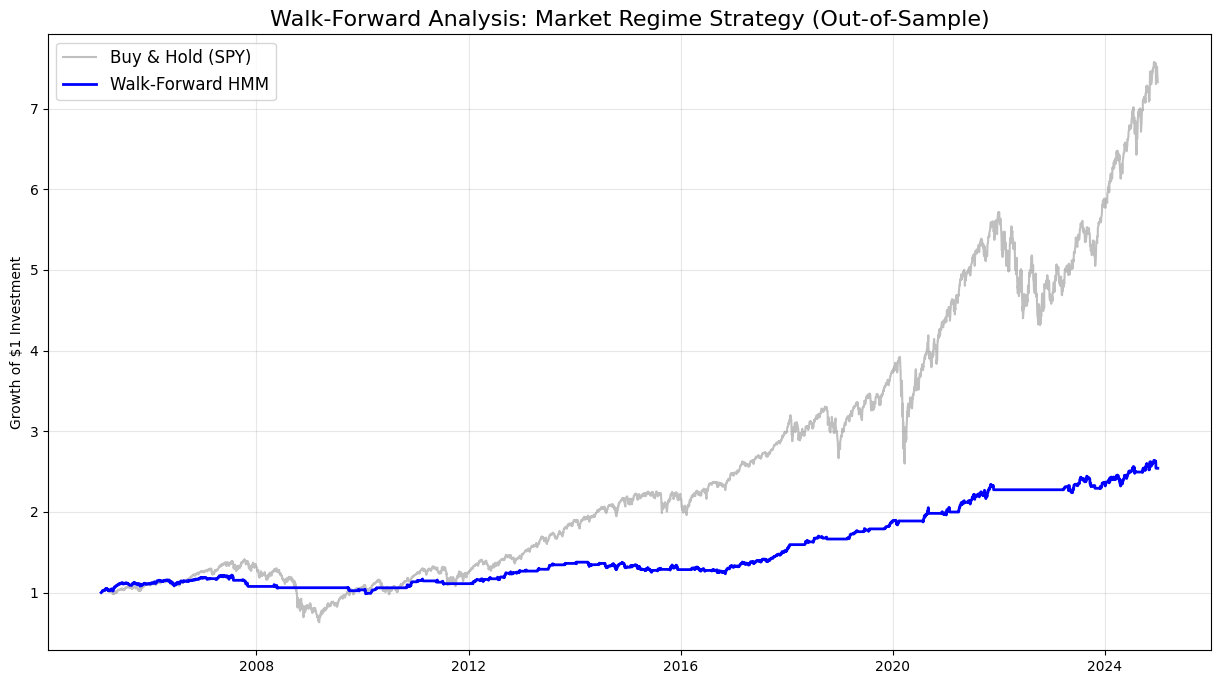

Metric                    | Buy & Hold      | HMM Strategy   
-----------------------------------------------------------------
Sharpe Ratio              | 0.52            | 0.73           
Annual Volatility         | 19.07%          | 6.43%          
Total Return              | 632.69%         | 154.10%        


In [23]:
import matplotlib.pyplot as plt

# Create the Final DataFrame
df_wf = pd.DataFrame({'Date': dates, 'WF_Signal': signals})
df_wf.set_index('Date', inplace=True)
df_final = df.join(df_wf, how='inner')

# Shift Signal by 1 day
df_final['WF_Signal'] = df_final['WF_Signal'].shift(1)

# Calculate Returns
df_final['WF_Strategy_Returns'] = df_final['Returns'] * df_final['WF_Signal']

# Calculate Cumulative Growth
df_final['Buy_Hold_Cum'] = np.exp(df_final['Returns'].cumsum())
df_final['WF_Strategy_Cum'] = np.exp(df_final['WF_Strategy_Returns'].cumsum())

# Plot Equity Curve
plt.figure(figsize=(15, 8))
plt.plot(df_final.index, df_final['Buy_Hold_Cum'], label='Buy & Hold (SPY)', color='gray', alpha=0.5)
plt.plot(df_final.index, df_final['WF_Strategy_Cum'], label='Walk-Forward HMM', color='blue', linewidth=2)

plt.title('Walk-Forward Analysis: Market Regime Strategy (Out-of-Sample)', fontsize=16)
plt.ylabel('Growth of $1 Investment')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Calculate & Print Metrics
total_ret_bh = df_final['Buy_Hold_Cum'].iloc[-1] - 1
total_ret_strat = df_final['WF_Strategy_Cum'].iloc[-1] - 1

vol_bh = df_final['Returns'].std() * np.sqrt(252)
vol_strat = df_final['WF_Strategy_Returns'].std() * np.sqrt(252)

sharpe_bh = (df_final['Returns'].mean() * 252) / vol_bh
sharpe_strat = (df_final['WF_Strategy_Returns'].mean() * 252) / vol_strat

print(f"{'Metric':<25} | {'Buy & Hold':<15} | {'HMM Strategy':<15}")
print("-" * 65)
print(f"{'Sharpe Ratio':<25} | {sharpe_bh:<15.2f} | {sharpe_strat:<15.2f}")
print(f"{'Annual Volatility':<25} | {vol_bh:<15.2%} | {vol_strat:<15.2%}")
print(f"{'Total Return':<25} | {total_ret_bh:<15.2%} | {total_ret_strat:<15.2%}")